In [15]:


import pandas as pd
from helm.benchmark.runner import InstanceGenerations,GenerationSummary
from typing import Any, List
import json
from helm.common.request import (GeneratedOutput, Token)

import PostMetric
import pandas as pd

from helm.benchmark.metrics.statistic import Stat
from typing import Dict, Optional

from helm.benchmark.augmentations.perturbation_description import (
    PerturbationDescription)
from dataclasses import dataclass
from process_gens import *
from process_gen_utils import *



processGens=ProcessGens()

#wmt modes
process_gen_modes=["wmt_samples0", "only_qwen_8b"]


#5 threads for llama1, 

processGens.init_with_mode(process_gen_modes)
root_folder, num_beams_list, models, custom_metrics, task_names, suite_name, instance_metrics, compare_metric = processGens.get_params()
compare_metric="example_comet"
examples_df, completions_df=get_dfs(processGens)

examples_df["rank"]=100-examples_df["example_idx"]
completions_df["rank"]=100-completions_df["example_idx"]


dfs_by_model={}
for model_name in examples_df['model'].unique():
    filtered_df = examples_df[examples_df["model"]==model_name]
    
    dfs_by_model[model_name]=filtered_df


all_dfs_by_model=dfs_by_model
df=next(iter(dfs_by_model.values()))


Init: process_gens_mode ['wmt_samples0', 'only_qwen_8b']
calculate_gen_summary_dict
snellius_copies/helm_output/sample_100_eval_1000/wmt_14_language_pair_de_en_/meta_llama_Llama_3.1_8B_Instruct/1_beams/runs/sample_100_eval_1000
get_metrics_dict
calculate_gen_summary_dict
snellius_copies/helm_output/sample_100_eval_500_first_inst_0/wmt_14_language_pair_de_en_/Qwen_Qwen3_8B/1_beams/runs/sample_100_eval_500_first_inst_0
get_metrics_dict
Index(['example_comet', 'beam_num', 'task_name', 'model', 'example_idx',
       'suite', 'instanceID', 'text', 'completion_length', 'output_logprob',
       'isCompletion'],
      dtype='object')
Num examples: 150000
Num completions: 1500


/var/folders/w4/6m47nb7x1cv2hsxbb89dmcz80000gn/T/ipykernel_90404/1159941081.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  completions_df["rank"]=100-completions_df["example_idx"]


In [35]:
print(f"\t root_folder: {root_folder} \n \t num_beams_list {num_beams_list} \n \t models: {models} \n \t custom_metrics{[metric.name() for metric in custom_metrics]}"+ 
    f"\n \t task_names {task_names} \n \t suite_name {suite_name} \n \t instance_metrics {instance_metrics}")
# instanceGeneration=get_first(processGens.first_run_instances)
print(examples_df.head(2))
print("num examples" ,len(examples_df))
print("num_completions", len(completions_df))
print(f"compare_metric mean: ",examples_df[[compare_metric]].mean())
#current belief: for each run_folder combo, there will be 100 instances and 100 examples per instance

	 root_folder: snellius_copies/helm_output 
 	 num_beams_list [1] 
 	 models: ['Qwen/Qwen3-8B'] 
 	 custom_metrics[]
 	 task_names ['wmt_14_language_pair_de_en_'] 
 	 suite_name sample_100_eval_500_first_inst_0 
 	 instance_metrics ['comet']
   example_comet  beam_num                    task_name  \
0       0.865341         1  wmt_14_language_pair_de_en_   
1       0.861965         1  wmt_14_language_pair_de_en_   

                              model  example_idx                 suite  \
0  meta_llama_Llama_3.1_8B_Instruct            0  sample_100_eval_1000   
1  meta_llama_Llama_3.1_8B_Instruct            1  sample_100_eval_1000   

   instanceID                                               text  \
0           0  He advised the parents of a boy whose penis ha...   
1           0  He advised the parents of a boy whose penis wa...   

   completion_length  output_logprob isCompletion  rank  
0                178       -8.308031         True   100  
1                177       -8.531994

First, we just look at the basic shape.

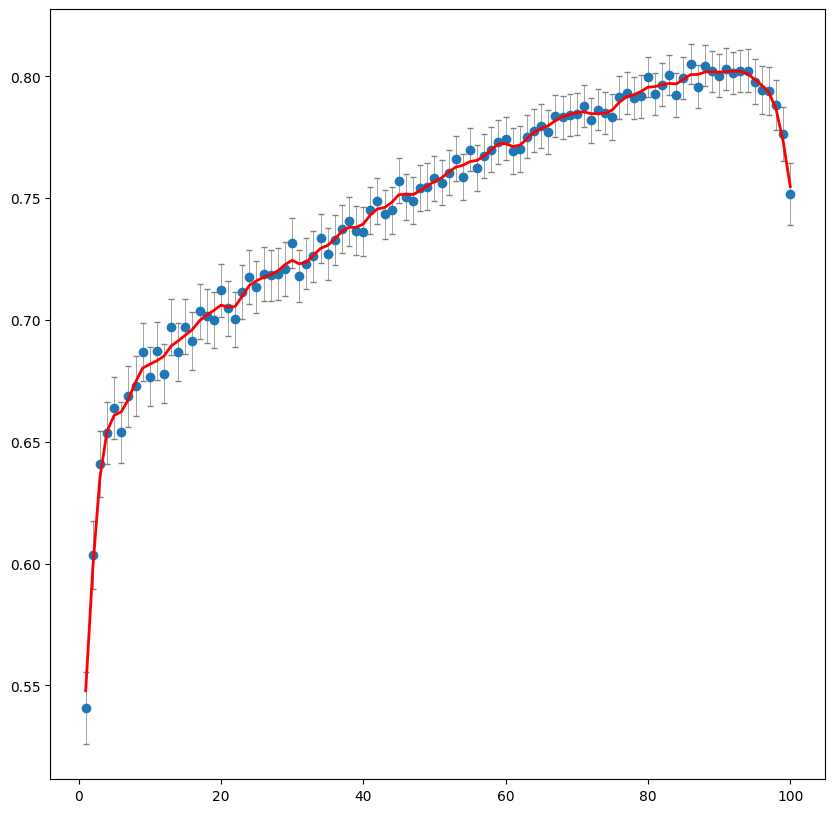

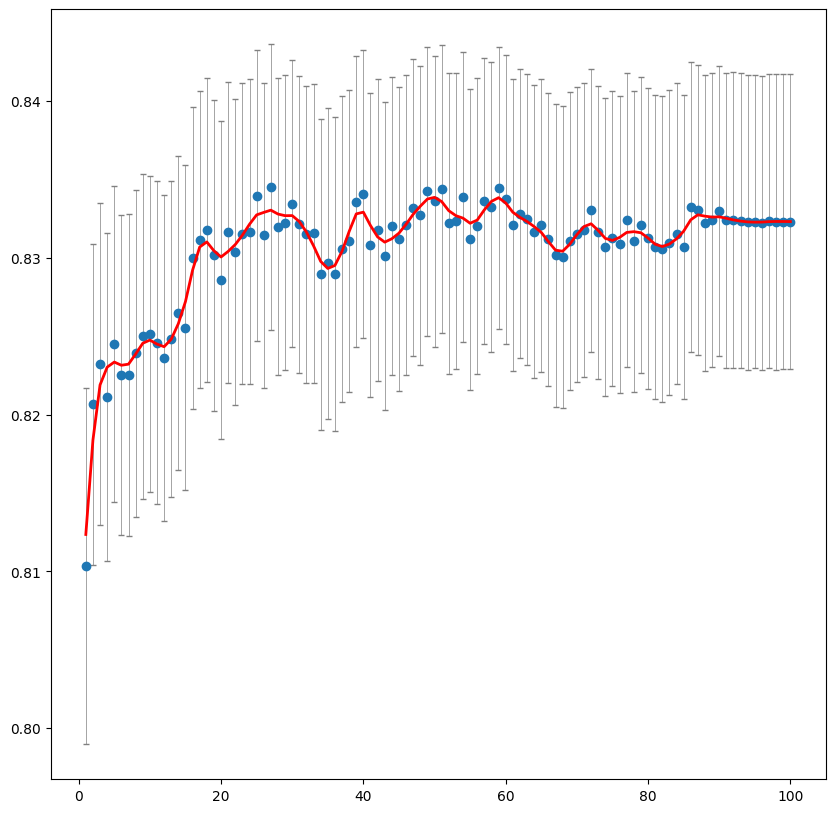

In [17]:
from scipy.interpolate import make_smoothing_spline
def plot_smooth_spline(df, xlabel, ylabel, groupby='example_idx', title=None, trend_line="None",ax=None, nbins=20, error_bar=False):
    if(ax is None):
        _, ax = plt.subplots(figsize=(10, 10))
    warnings.simplefilter(action='ignore', category=FutureWarning)

    
    grouped = df.groupby(groupby)[[xlabel, ylabel]].agg(['mean', 'count', 'std'])    
    grouped = grouped.sort_values(by=(xlabel, 'mean'))

    x = grouped[(xlabel, 'mean')].values
    y = grouped[(ylabel, 'mean')].values
    

    yerr = grouped[(ylabel, 'std')].values
    yerr=[]
    for i in grouped.index:
        # print(grouped.loc[i][ylabel])
        _, c, s = grouped.loc[i][ylabel]
        yerr.append(1.96*s/math.sqrt(c))



    if(error_bar):
        ax.errorbar(x, y, yerr=yerr, fmt='o', ecolor='gray', capsize=2, elinewidth=0.5, label='Data with std dev', zorder=00)
    else:
        ax.scatter(x,y)
    spl = make_smoothing_spline(x, y)
    ax.plot(x, spl(x), '-',linewidth=2, color="red", zorder=10)



for idx, (model_name, filtered_df) in enumerate(dfs_by_model.items()):
    plot_smooth_spline(df=filtered_df, xlabel="rank",groupby='example_idx', ylabel=compare_metric, title="", error_bar=True)

We calculate some metrics

In [18]:
#first: I calculate win rates

def get_iom_metrics_dict(df,compare_metric,ax=None):
    # plot_grouped(df, xlabel, ylabel, groupby='example_idx', title=None, trend_line="None",ax=None, nbins=20):
    # grouped = df.groupby("example_idx")[[xlabel, ylabel]].agg(['mean', 'count', 'std'])

    max_example_idx = df["example_idx"].max()
    num_ranks=max_example_idx+1
    # pivoted = df.pivot(columns='example_idx', values=compare_metric )
    # pivoted_mean=pivoted.mean()
    pivoted = df.pivot(index="instanceID",columns="example_idx", values=compare_metric )
    # print(pivoted.head(2))
    mean_pivoted=pivoted.mean()
    ave_val=mean_pivoted.mean()

    # pivoted_x = df.pivot(columns="example_idx", values="output_logprob").mean()
    
    best_rank = mean_pivoted.idxmax()
    ranks_effected=best_rank
    percent_effected=ranks_effected / num_ranks
    score_diff=0

    win_rate_by_col=[-1]*(best_rank+1)
    for compare_rank in range(best_rank+1):
        win_rate_col_name=f"win_rate_{compare_rank}"
        pivoted[win_rate_col_name] = pivoted.apply( lambda row: get_win_rate(row,compare_rank, best_rank) , axis=1)
        win_rate_by_col[compare_rank] = pivoted[win_rate_col_name].mean()

    win_rate=win_rate_by_col[0]
    # print("win_rate_by_col",win_rate_by_col)

    for compare_rank in range(best_rank):
        score_diff+= mean_pivoted[best_rank]-mean_pivoted[compare_rank]
    

    effect_size=score_diff*percent_effected
    average_diff=score_diff/ranks_effected
    effect_diff=mean_pivoted[best_rank]-mean_pivoted[0]

    average_diff_norm=average_diff/ave_val
    effect_diff_norm=effect_diff/ave_val
    effect_size_norm=effect_size /ave_val

    return {
        # "effect_size": effect_size,
        # "average_diff": average_diff,
        # "effect_diff": effect_diff,
        "percent_effected":percent_effected,
        "win_rate":win_rate,

        "average_diff_norm":average_diff_norm,
        "effect_diff_norm":effect_diff_norm,
        "effect_size_norm":effect_size_norm
    }



iom_metrics_dict_by_model={}
for idx, (model_name, filtered_df) in enumerate(dfs_by_model.items()):
    # print(model_name)
    iom_metrics_dict_by_model[model_name]=get_iom_metrics_dict(filtered_df, compare_metric=compare_metric)
    print(iom_metrics_dict_by_model[model_name])




# 14% effected, 






    


{'percent_effected': np.float64(0.14), 'win_rate': np.float64(0.5205), 'average_diff_norm': np.float64(0.015042813671901004), 'effect_diff_norm': np.float64(0.07155627229668524), 'effect_size_norm': np.float64(0.02948391479692597)}
{'percent_effected': np.float64(0.73), 'win_rate': np.float64(0.515), 'average_diff_norm': np.float64(0.0030292415010853826), 'effect_diff_norm': np.float64(0.0026411475392891307), 'effect_size_norm': np.float64(0.16142827959284003)}


Ok, we've identified the "peak" of the distribution. Now, let's only look at the best and worst column

Completion amount 0.7516635504513979
Best amount 0.8050621095895767


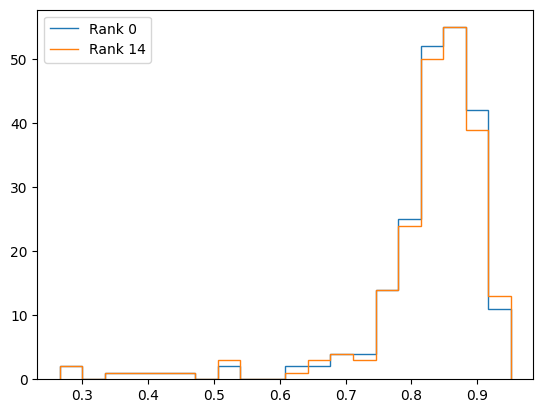

In [42]:
#ok, I only want to keep columns where the rank is 14 or 0
df=dfs_by_model["meta_llama_Llama_3.1_8B_Instruct"]

max_example_idx = df["example_idx"].max()
num_ranks=max_example_idx+1
pivoted = df.pivot(index="instanceID",columns="example_idx", values=compare_metric )
mean_pivoted=pivoted.mean()
ave_val=mean_pivoted.mean()
best_rank = mean_pivoted.idxmax()

print(f"Completion amount {mean_pivoted[0]}")
print(f"Best amount {mean_pivoted[best_rank]}")

best_and_first=filtered_df[ filtered_df['example_idx'].isin([0, best_rank])]

cols_to_keep=["example_comet", "example_idx", "output_logprob", "completion_length"]
best_and_first=best_and_first[["example_comet", "example_idx", "output_logprob", "completion_length"]]

best_and_first_grouped=best_and_first.groupby(["completion_length", "example_idx"]).mean().reset_index()




# #we want to see, for each completion length, the average metric score
# #we will do this for both ranks, 0 and 14

# We can set the number of bins with the *bins* keyword argument.




for idx, rank in enumerate([0, best_rank]):
    cur_df=best_and_first_grouped[best_and_first_grouped["example_idx"]==rank]
    x=cur_df["example_comet"]
    counts, bins = np.histogram(x, bins=20)
    plt.stairs(counts, bins, label=f"Rank {rank}")
plt.legend()



219
219
211
211


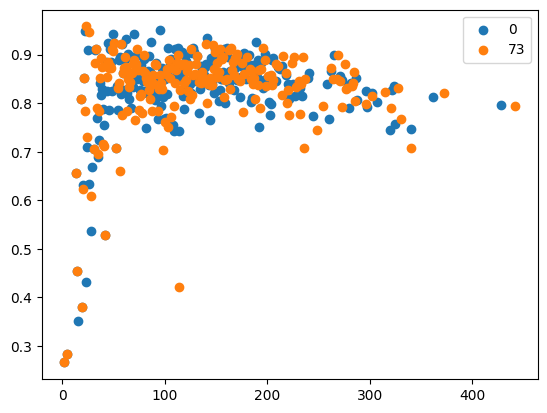

In [20]:

_, ax = plt.subplots()


# #we want to see, for each completion length, the average metric score
# #we will do this for both ranks, 0 and 14

for rank in [0, best_rank]:
    cur_df=best_and_first_grouped[best_and_first_grouped["example_idx"]==rank]
    x=cur_df["completion_length"]
    y=cur_df["example_comet"]
    print(len(x))
    print(len(y))
    ax.scatter(x,y, label=rank)
    ax.legend()


In [21]:
filtered_df["logprob_per_length"]=filtered_df["output_logprob"]/ filtered_df["completion_length"]

filtered_df['rank2'] = filtered_df.groupby('instanceID')['logprob_per_length'].rank(method='first', ascending=True) - 1
filtered_df['rank2'] = filtered_df['rank2'].astype(int)



/var/folders/w4/6m47nb7x1cv2hsxbb89dmcz80000gn/T/ipykernel_90404/3553070699.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df["logprob_per_length"]=filtered_df["output_logprob"]/ filtered_df["completion_length"]
/var/folders/w4/6m47nb7x1cv2hsxbb89dmcz80000gn/T/ipykernel_90404/3553070699.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['rank2'] = filtered_df.groupby('instanceID')['logprob_per_length'].rank(method='first', ascending=True) - 1
/var/folders/w4/6m47nb7x1cv2hsxbb89dmc

<Axes: xlabel='rank2', ylabel='example_comet'>

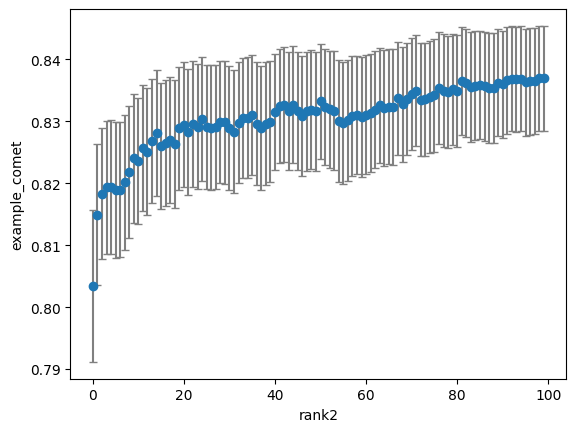

In [43]:
plot_grouped(filtered_df, "rank2", compare_metric, groupby='rank2', title=None, trend_line="None",ax=None)

In [23]:
#ok, we just want to predict
#example metric using length and rank

import statsmodels.api as sm
best_and_first["is_completion"]=(best_and_first["example_idx"]==0).astype(int)

X = best_and_first[['completion_length', 'is_completion']]
X = sm.add_constant(X) 
y = best_and_first['example_comet']

model = sm.OLS(y, X).fit()

print(model.summary())

#so, ideally is_completion should be negatively correlated with example_comet


                            OLS Regression Results                            
Dep. Variable:          example_comet   R-squared:                       0.017
Model:                            OLS   Adj. R-squared:                  0.015
Method:                 Least Squares   F-statistic:                     8.755
Date:                Tue, 08 Jul 2025   Prob (F-statistic):           0.000170
Time:                        15:37:33   Log-Likelihood:                 836.72
No. Observations:                1000   AIC:                            -1667.
Df Residuals:                     997   BIC:                            -1653.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.8116      0.00

In [24]:
#Try to predict comet using completion_length and output_logprob for entire dataset
#Find that neither have much effect
X = filtered_df[['completion_length', 'output_logprob']]
X = sm.add_constant(X) 
y = filtered_df['example_comet']

model = sm.OLS(y, X).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:          example_comet   R-squared:                       0.131
Model:                            OLS   Adj. R-squared:                  0.131
Method:                 Least Squares   F-statistic:                     3757.
Date:                Tue, 08 Jul 2025   Prob (F-statistic):               0.00
Time:                        15:37:33   Log-Likelihood:                 43072.
No. Observations:               50000   AIC:                        -8.614e+04
Df Residuals:                   49997   BIC:                        -8.611e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.8110      0.00

In [25]:
print(df.columns)

Index(['example_comet', 'beam_num', 'task_name', 'model', 'example_idx',
       'suite', 'instanceID', 'text', 'completion_length', 'output_logprob',
       'isCompletion', 'rank', 'logprob_per_length', 'rank2'],
      dtype='object')


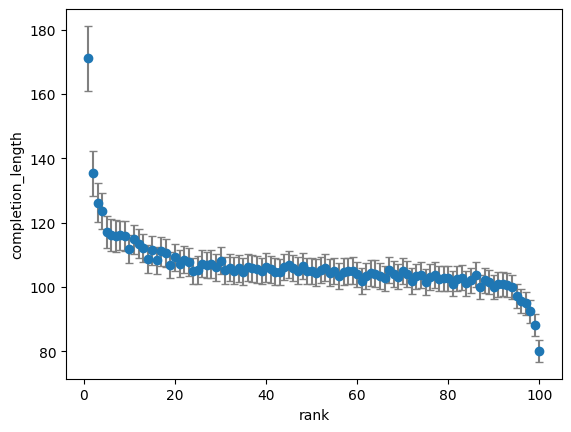

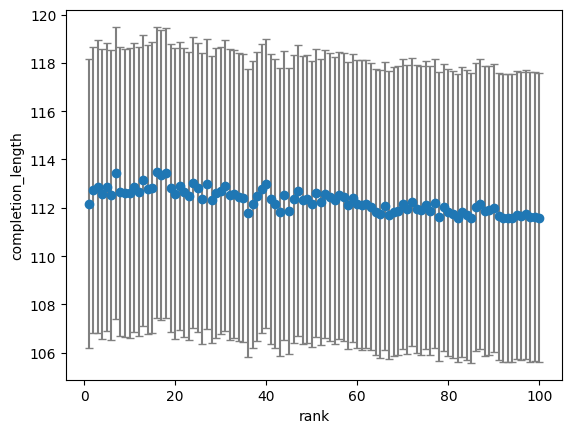

In [26]:
for idx, (model_name, filtered_df) in enumerate(dfs_by_model.items()):
    plot_grouped(filtered_df, "rank", "completion_length", groupby='example_idx', title=None, trend_line="None",ax=None)